In [1]:
import subprocess
subprocess.check_output(["maturin", "develop"])
import time

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/wint3rmute/code/luthier/.venv/bin/python
📡 Using build options features from pyproject.toml
    Blocking waiting for file lock on package cache
    Blocking waiting for file lock on package cache
    Blocking waiting for file lock on package cache
    Blocking waiting for file lock on build directory
   Compiling pyo3-build-config v0.18.3
   Compiling pyo3-ffi v0.18.3
   Compiling pyo3 v0.18.3
   Compiling numpy v0.18.0
   Compiling luthier v0.1.0 (/home/wint3rmute/code/luthier)
   --> src/ladder_filter.rs:132:8
    |
110 | impl LadderFilter {
    | ----------------- method in this implementation
...
132 |     fn run_ladder_nonlinear(&mut self, input: f64) {
    |        ^^^^^^^^^^^^^^^^^^^^
    |
    = note: `#[warn(dead_code)]` on by default

    Finished dev [unoptimized + debuginfo] target(s) in 5.87s
⚠️ Warning: Failed to set rpath for /home/wint3rmute/code/luthier/target/debug/libluthier.so

In [2]:
import numpy as np
import audioflux as af
from audioflux.type import SpectralFilterBankScaleType
from IPython.display import Audio, display, Image, HTML
import matplotlib.pyplot as plt
from audioflux.display import fill_spec
import random
import PIL
from tqdm.notebook import tqdm
from copy import deepcopy
from IPython.display import clear_output
import librosa
from scipy.optimize import differential_evolution
import soundfile as sf
from multiprocessing import Pool
import os
from luthier.luthier import DspGraph, SineOscillator, Multiplier, HarmonicMultiplier, Reverb, Sum, ADSR, SquareOscillator, LowPassFilter, HighPassFilter
from luthier.dsp import Sample
plt.rcParams['figure.dpi'] = 110
SAMPLE_RATE = 22050

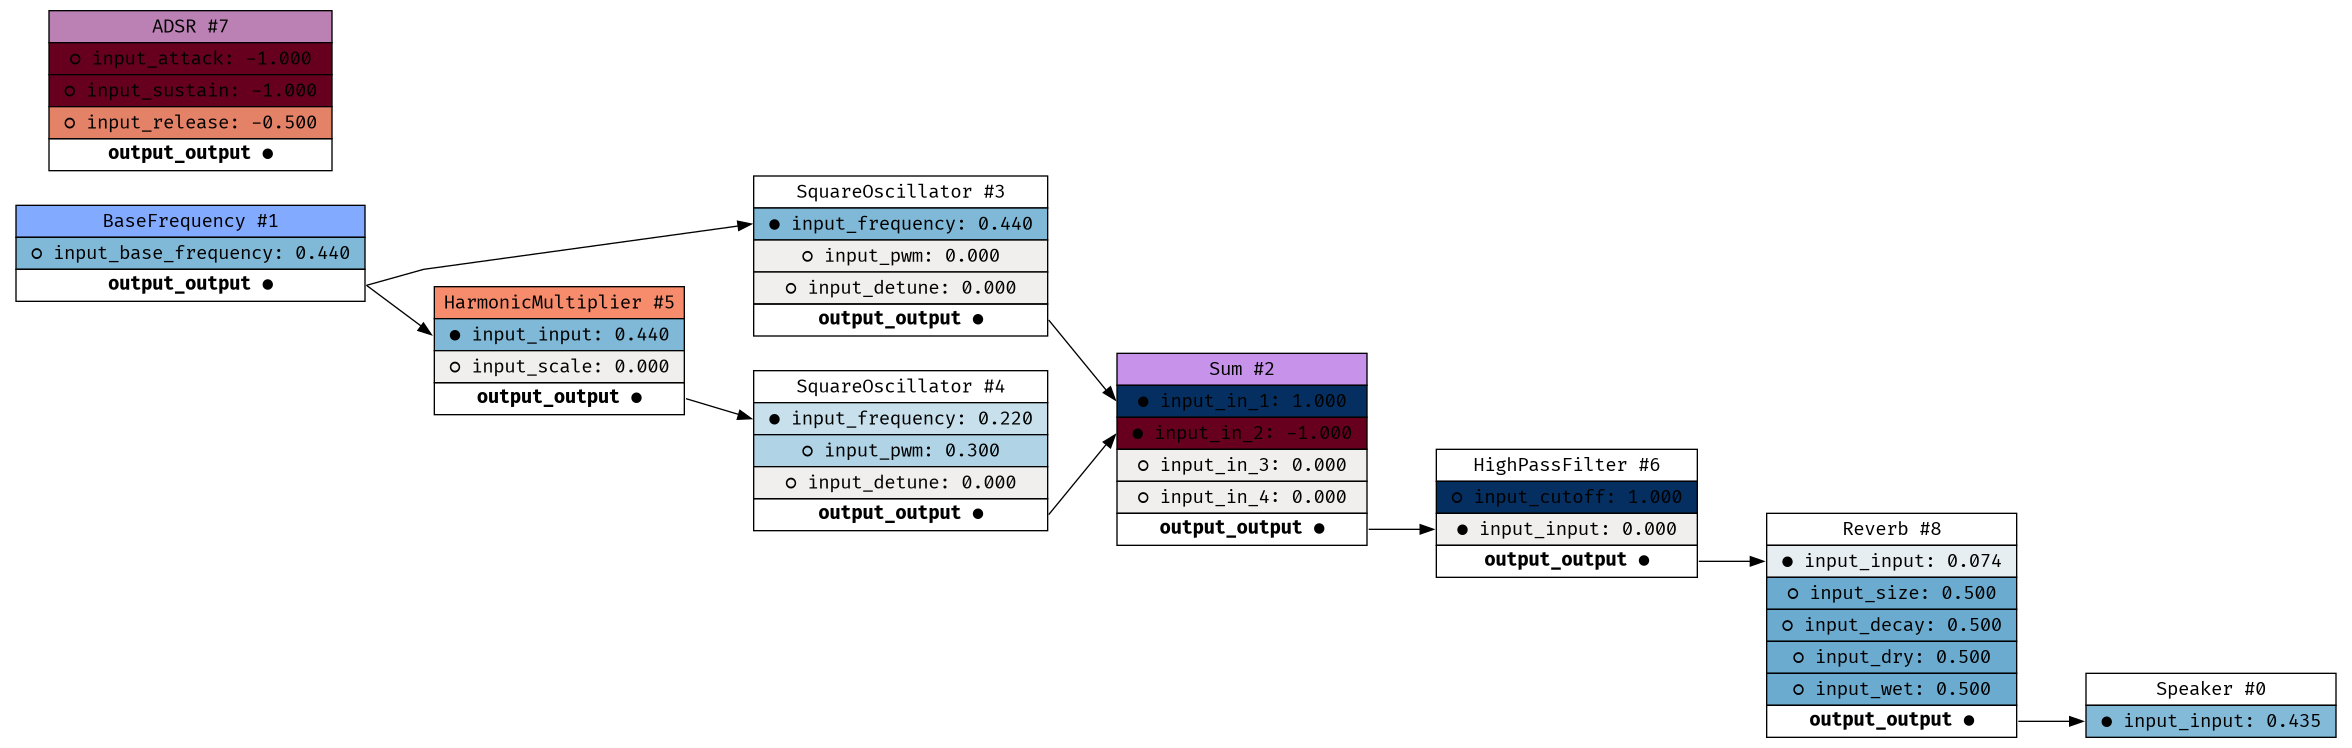

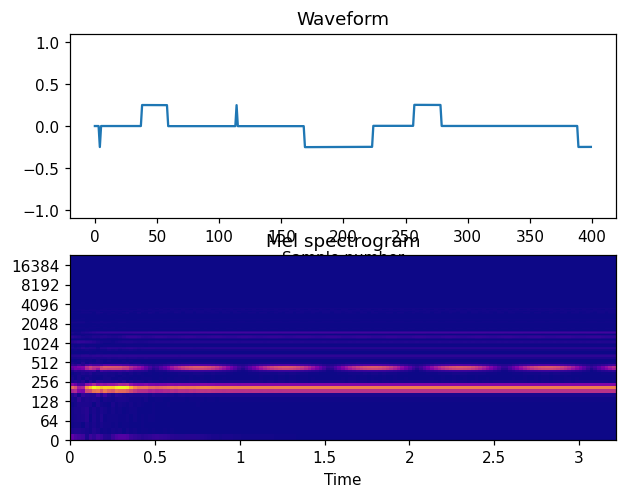

In [10]:
def square_analog():
    graph = DspGraph()

    mixer = graph.add_sum(Sum())

    s = SquareOscillator()
    s.input_pwm = 0.0
    s = graph.add_square(s)

    s2 = SquareOscillator()
    s2.input_pwm = 0.3

    s2 = graph.add_square(s2)

    osc2_mult = HarmonicMultiplier()

    osc2_mult = graph.add_harmonic_multiplier(osc2_mult)

    graph.patch(graph.base_frequency_node_id, "output_output", osc2_mult, "input_input")
    graph.patch(graph.base_frequency_node_id, "output_output", s, "input_frequency")
    graph.patch(osc2_mult, "output_output", s2, "input_frequency")
    graph.patch(s2, "output_output", mixer, "input_in_2")
    graph.patch(s, "output_output", mixer, "input_in_1")

    # f = LowPassFilter()
    f = HighPassFilter()
    
    # f.input_cutoff = 0.0001
    f.input_cutoff = 1.0
    # f = graph.add_lowpass(f)
    f = graph.add_highpass(f)
    
    
    filter_adsr = ADSR()
    filter_adsr.input_attack = -1.0
    filter_adsr.input_sustain = -1.0
    filter_adsr.input_release = -0.5
    filter_adsr = graph.add_adsr(filter_adsr)
    # graph.patch(filter_adsr, "output_output",  f, "input_cutoff")

    # osc_mult = Multiplier()
    # osc_mult.input_scale = 1.0
    # osc_mult = graph.add_multiplier(osc_mult)

    r = Reverb()
    r = graph.add_reverb(r)

    graph.patch(mixer, "output_output", f, "input_input")
    graph.patch(f, "output_output", r, "input_input")
    graph.patch(r, "output_output", graph.speaker_node_id, "input_input")


    return graph

graph = square_analog()
# graph.randomize_inputs()
audio = Sample(graph.play(SAMPLE_RATE*7))
target_audio = audio
display(Image(graph.draw()))

fig, (ax, ax2) = plt.subplots(2)
audio.plot_waveform(ax)
audio.plot_spectrogram(ax2)
audio.show_player()

plt.show()